<a href="https://colab.research.google.com/github/smahesh2694/NEU_XAI/blob/master/MVTec_ResNet101V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
cd /content/drive/My Drive/data

/content/drive/My Drive/data


In [4]:
import pandas as pd
import numpy as np
import os
import keras
import cv2
import matplotlib.pyplot as plt
from keras.layers.core import Dense
from keras.layers import GlobalAveragePooling2D, Dropout
from keras.applications import ResNet50, ResNet50V2, ResNet101V2
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.optimizers import Adam, SGD
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix

Using TensorFlow backend.


In [5]:
img_height = 224
img_width = 224

base_model = ResNet101V2(weights= 'imagenet', include_top=False, input_shape= (img_height,img_width,3))













171319296/171317808 [==============================] - 13s 0us/step


In [6]:
num_classes = 30

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x=Dense(512, activation='relu')(x) 
preds = Dense(num_classes, activation= 'softmax')(x)
model = Model(inputs = base_model.input, outputs = preds)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [8]:
v = 0
a = model.layers
print("Total layers in ResNet101V2 : ", len(a))
for i in range(len(a)):
            if type(a[i]) == keras.layers.convolutional.Conv2D:
                v += 1
                # print(a[i])
print("No. of Conv2D layers : ", v)

Total layers in ResNet101V2 :  381
No. of Conv2D layers :  104


In [0]:
base_model.trainable = False

In [0]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True, 
                                 vertical_flip=True,
                                 validation_split=0.2)

In [0]:
bs = 16
CLASSES = ['defective_bottle','defective_cable','defective_capsule','defective_carpet',
           'defective_grid','defective_hazelnut','defective_leather','defective_metalnut',
           'defective_pill','defective_screw','defective_tile','defective_toothbrush',
           'defective_transistor','defective_wood','defective_zipper','good_bottle',
           'good_cable','good_capsule','good_carpet','good_grid',
           'good_hazelnut','good_leather','good_metalnut','good_pill',
           'good_screw','good_tile','good_toothbrush','good_transistor',
           'good_wood','good_zipper']

In [12]:
train_generator=train_datagen.flow_from_directory('train',  
                                                 target_size=(224,224),     
                                                 batch_size=bs,
                                                 class_mode='categorical',                                                 
                                                 shuffle=True,
                                                 subset='training',
                                                 classes=CLASSES)

Found 2884 images belonging to 30 classes.


In [13]:
label_map = (train_generator.class_indices)
print("Label map: ",label_map)

Label map:  {'defective_bottle': 0, 'defective_cable': 1, 'defective_capsule': 2, 'defective_carpet': 3, 'defective_grid': 4, 'defective_hazelnut': 5, 'defective_leather': 6, 'defective_metalnut': 7, 'defective_pill': 8, 'defective_screw': 9, 'defective_tile': 10, 'defective_toothbrush': 11, 'defective_transistor': 12, 'defective_wood': 13, 'defective_zipper': 14, 'good_bottle': 15, 'good_cable': 16, 'good_capsule': 17, 'good_carpet': 18, 'good_grid': 19, 'good_hazelnut': 20, 'good_leather': 21, 'good_metalnut': 22, 'good_pill': 23, 'good_screw': 24, 'good_tile': 25, 'good_toothbrush': 26, 'good_transistor': 27, 'good_wood': 28, 'good_zipper': 29}


In [14]:
val_generator=train_datagen.flow_from_directory('train', 
                                                 target_size=(224,224),  
                                                 batch_size=bs,
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                 subset='validation')

Found 704 images belonging to 30 classes.


In [15]:
step_size_train = train_generator.n//train_generator.batch_size
print("Training step size: ",step_size_train)

step_size_val = (val_generator.n//val_generator.batch_size) + 1
print("Validation step size: ",step_size_val)

Training step size:  180
Validation step size:  45


In [16]:
from keras.callbacks import LearningRateScheduler

sgd = SGD() #, momentum=0.9, decay=0.01, nesterov=False)

model.compile(optimizer= sgd, loss='categorical_crossentropy', metrics=['acc'])

In [17]:
initial_epochs = 50        #change
import math

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
       self.losses = []
       self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
       self.losses.append(logs.get('loss'))
       self.lr.append(step_decay(len(self.losses)))

def step_decay(epoch):
  initial_lrate = 0.1
  drop = 0.25
  drop_every = 5.0        #change
  lrate = initial_lrate * math.pow(drop,
                                   math.floor((1+epoch)/drop_every))
  return lrate

loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay)
callbacks_list = [loss_history, lrate]

history = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data=val_generator,
                   validation_steps=step_size_val,                
                   epochs=initial_epochs,
                   callbacks = callbacks_list)

# model.save('/content/drive/My Drive/xai_model/MVTec_25_2.h5')
# model.save_weights('/content/drive/My Drive/xai_model/MVTec_25_weights_2.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
180/180 [==============================] - 2742s 15s/step - loss: 1.2304 - acc: 0.6417 - val_loss: 0.7611 - val_acc: 0.6625
Epoch 2/50
180/180 [==============================] - 196s 1s/step - loss: 0.6688 - acc: 0.7354 - val_loss: 0.6492 - val_acc: 0.7597
Epoch 3/50
180/180 [==============================] - 194s 1s/step - loss: 0.5876 - acc: 0.7566 - val_loss: 1.1442 - val_acc: 0.6125
Epoch 4/50
180/180 [==============================] - 190s 1s/step - loss: 0.5920 - acc: 0.7573 - val_loss: 0.4977 - val_acc: 0.7750
Epoch 5/50
180/180 [==============================] - 189s 1s/step - loss: 0.4139 - acc: 0.8347 - val_loss: 0.3867 - val_acc: 0.8431
Epoch 6/50
180/180 [==============================] - 187s 1s/step - loss: 0.3687 - acc: 0.8490 - val_loss: 0.4024 - val_acc: 0.8486
Epoch 7/50
180/180 [==============================] - 187s 1s/step - loss: 0.3491 - acc: 0.8601 - val_lo

In [0]:
# model.save('/content/drive/My Drive/xai_model/MVTec_RN101_50.h5')
# model.save_weights('/content/drive/My Drive/xai_model/MVTec_RN101_50_weights.h5')

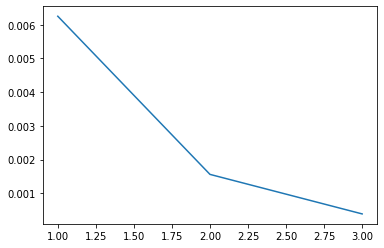

In [0]:
plt.plot((1,2,3),loss_history.lr)

In [19]:
scores = model.evaluate_generator(generator=val_generator,
                         steps=step_size_val,verbose = 1)

print('Validating loss:', scores[0])
print('Validating accuracy:', scores[1])

45/45 [==============================] - 36s 801ms/step
Validating loss: 0.28727348115709095
Validating accuracy: 0.8875


In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

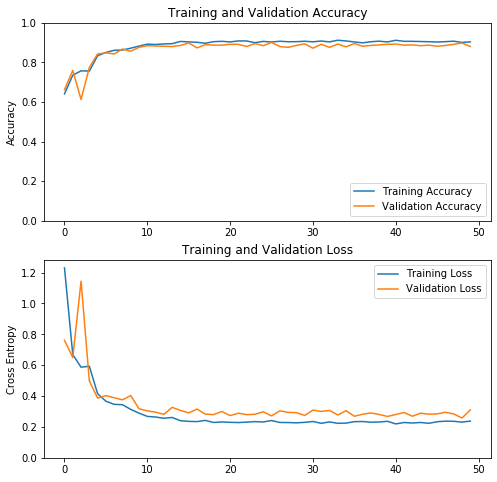

In [21]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
# plt.savefig('/content/drive/My Drive/xai_model/MVTec_RN101_50.jpg')
plt.show()

In [0]:
# # memory footprint support libraries/code
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
# !pip install psutil
# !pip install humanize
# import psutil
# import humanize
# import os
# import GPUtil as GPU
# GPUs = GPU.getGPUs()
# # XXX: only one GPU on Colab and isn’t guaranteed
# gpu = GPUs[0]
# def printm():
#  process = psutil.Process(os.getpid())
#  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
#  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
# printm() 

In [0]:
# !kill -9 -1

In [0]:
# model = load_model('/content/drive/My Drive/xai_model/MVTec_25_2.h5')

In [0]:
test_datagen = ImageDataGenerator(rescale=1./255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 vertical_flip=True)

In [23]:
bs_test = 8
test_generator = test_datagen.flow_from_directory('test',
                                                  target_size=(224,224),     
                                                  batch_size=bs_test,
                                                  class_mode='categorical',
                                                  shuffle = False)

Found 1542 images belonging to 30 classes.


In [24]:
step_size_test = (test_generator.n//test_generator.batch_size)+1
print(step_size_test)
test_generator.reset()

193


In [41]:
predIndxs = model.predict_generator(test_generator, steps = step_size_test, verbose=1 )

193/193 [==============================] - 76s 393ms/step


In [42]:
acc_o = np.sum(np.argmax(predIndxs, axis=1).astype('int') == test_generator.labels) / test_generator.n
print(acc_o)

0.8884565499351491


In [43]:
print(len(predIndxs))
print(len(test_generator.labels))

1542
1542


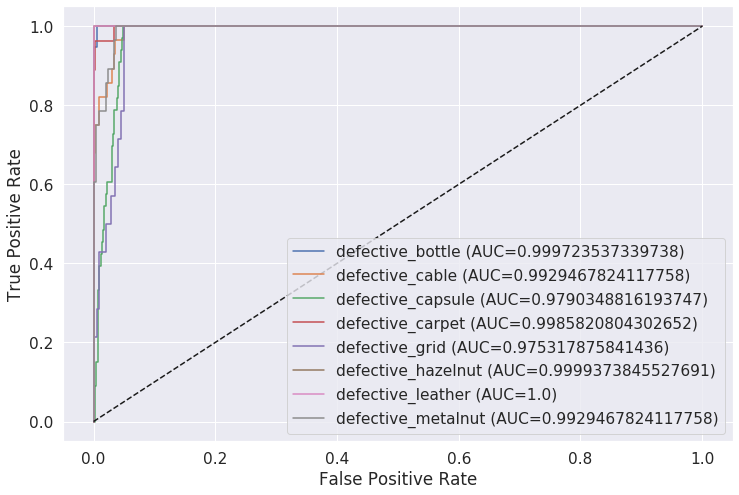

In [44]:
auc = []
fpr_def = []
tpr_def = []
for iter_class, c in enumerate(CLASSES[:8]):
    class_target = (test_generator.labels == iter_class).astype('int')
    class_pred = predIndxs[:, iter_class]
    # Calculate AUC
    class_auc = roc_auc_score(class_target, class_pred)
    # Calculate TPR, FPR
    class_fpr, class_tpr, _ = roc_curve(class_target, class_pred)
    auc.append(class_auc)
    fpr_def.append(class_fpr)
    tpr_def.append(class_tpr)
    # Plot
    plt.plot(class_fpr, class_tpr, label=c + ' (AUC=' + str((class_auc)) + ')')
x = np.linspace(0, 1, num=100)
plt.plot(x, x, 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

fig = plt.gcf()
fig.set_size_inches(12, 8)

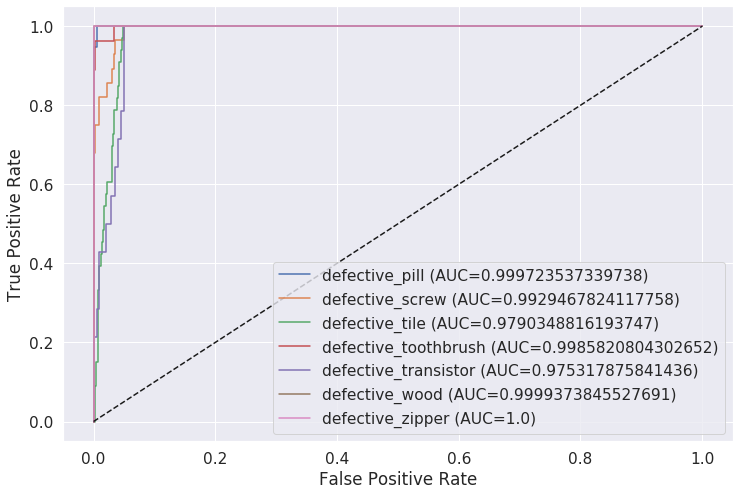

In [45]:
auc = []
fpr_def = []
tpr_def = []
for iter_class, c in enumerate(CLASSES[8:15]):
    class_target = (test_generator.labels == iter_class).astype('int')
    class_pred = predIndxs[:, iter_class]
    # Calculate AUC
    class_auc = roc_auc_score(class_target, class_pred)
    # Calculate TPR, FPR
    class_fpr, class_tpr, _ = roc_curve(class_target, class_pred)
    auc.append(class_auc)
    fpr_def.append(class_fpr)
    tpr_def.append(class_tpr)
    # Plot
    plt.plot(class_fpr, class_tpr, label=c + ' (AUC=' + str((class_auc)) + ')')
x = np.linspace(0, 1, num=100)
plt.plot(x, x, 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

fig = plt.gcf()
fig.set_size_inches(12, 8)

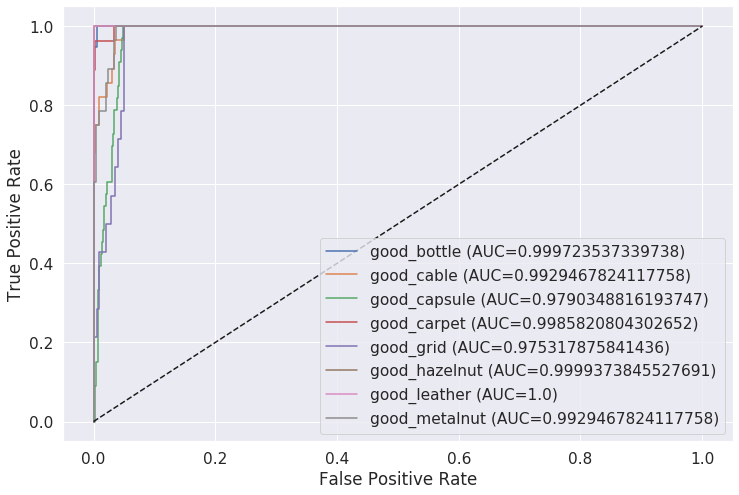

In [46]:
auc = []
fpr_def = []
tpr_def = []
for iter_class, c in enumerate(CLASSES[15:23]):
    class_target = (test_generator.labels == iter_class).astype('int')
    class_pred = predIndxs[:, iter_class]
    # Calculate AUC
    class_auc = roc_auc_score(class_target, class_pred)
    # Calculate TPR, FPR
    class_fpr, class_tpr, _ = roc_curve(class_target, class_pred)
    auc.append(class_auc)
    fpr_def.append(class_fpr)
    tpr_def.append(class_tpr)
    # Plot
    plt.plot(class_fpr, class_tpr, label=c + ' (AUC=' + str((class_auc)) + ')')
x = np.linspace(0, 1, num=100)
plt.plot(x, x, 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

fig = plt.gcf()
fig.set_size_inches(12, 8)

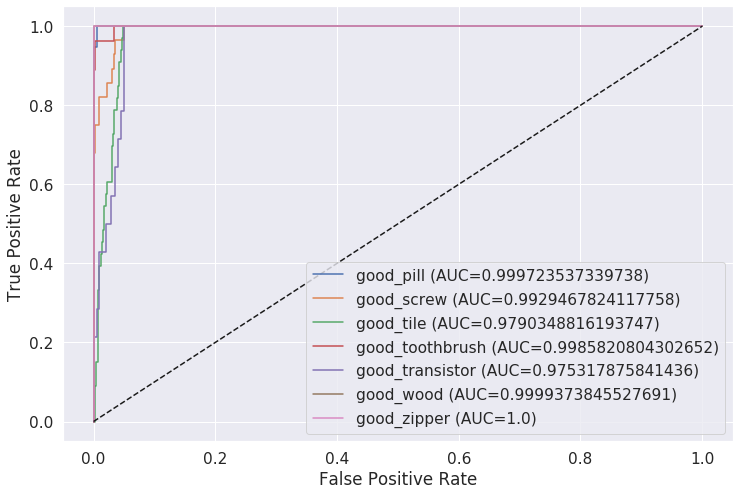

In [47]:
auc = []
fpr_def = []
tpr_def = []
for iter_class, c in enumerate(CLASSES[23:30]):
    class_target = (test_generator.labels == iter_class).astype('int')
    class_pred = predIndxs[:, iter_class]
    # Calculate AUC
    class_auc = roc_auc_score(class_target, class_pred)
    # Calculate TPR, FPR
    class_fpr, class_tpr, _ = roc_curve(class_target, class_pred)
    auc.append(class_auc)
    fpr_def.append(class_fpr)
    tpr_def.append(class_tpr)
    # Plot
    plt.plot(class_fpr, class_tpr, label=c + ' (AUC=' + str((class_auc)) + ')')
x = np.linspace(0, 1, num=100)
plt.plot(x, x, 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

fig = plt.gcf()
fig.set_size_inches(12, 8)

In [49]:
predIndxs_max = np.argmax(predIndxs, axis=1)
print(classification_report(test_generator.classes, predIndxs_max, target_names=test_generator.class_indices.keys()))

                      precision    recall  f1-score   support

    defective_bottle       1.00      0.89      0.94        19
     defective_cable       0.93      0.50      0.65        28
   defective_capsule       0.00      0.00      0.00        33
    defective_carpet       1.00      0.89      0.94        27
      defective_grid       0.00      0.00      0.00        14
  defective_hazelnut       1.00      0.90      0.95        21
   defective_leather       1.00      1.00      1.00        28
  defective_metalnut       1.00      0.46      0.63        28
      defective_pill       0.86      0.14      0.24        42
     defective_screw       0.00      0.00      0.00        17
      defective_tile       1.00      0.80      0.89        25
defective_toothbrush       1.00      0.22      0.36         9
defective_transistor       0.67      0.17      0.27        12
      defective_wood       1.00      0.89      0.94        18
    defective_zipper       0.97      0.78      0.86        36
       

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



In [50]:
print('Confusion matrix:')
cm = confusion_matrix(test_generator.classes,predIndxs_max)
print(cm)

total = sum(sum(cm))
print("Total test images: ", total)
acc = (cm[0, 0] + cm[1, 1] + cm[2, 2] + cm[3, 3] + cm[4, 4] + cm[5, 5] + cm[6, 6] +
       cm[7, 7] + cm[8, 8] + cm[9, 9] + cm[10, 10] + cm[11, 11] + cm[12, 12] +
       cm[13, 13] + cm[14, 14] + cm[15, 15] + cm[16, 16] + cm[17, 17] + cm[18, 18] +
       cm[19, 19] + cm[20, 20] + cm[21, 21] + cm[22, 22] + cm[23, 23] + cm[24, 24] +
       cm[25, 25] + cm[26, 26] + cm[27, 27] + cm[28, 28] + cm[29, 29]) / total
print("Accuracy: {:.3f}".format(acc))
print("Lables:")
print("x axis: Predicted")
print("y axis: Actual")

Confusion matrix:
[[ 17   0   0   0   0   0   0   0   0   0   0   0   0   0   0   2   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  14   0   0   0   0   0   0   0   0   0   0   0   0   0   0  14   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  33
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  24   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    3   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0  14   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  19   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   2   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  28   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  13   0   0   0   0   0   0   0   0   0   0
    0   0   0   0  15   0   0   0

In [0]:
# normalized_cm = cm/total
# print('Normalized Confusion matrix:')
# print(normalized_cm)

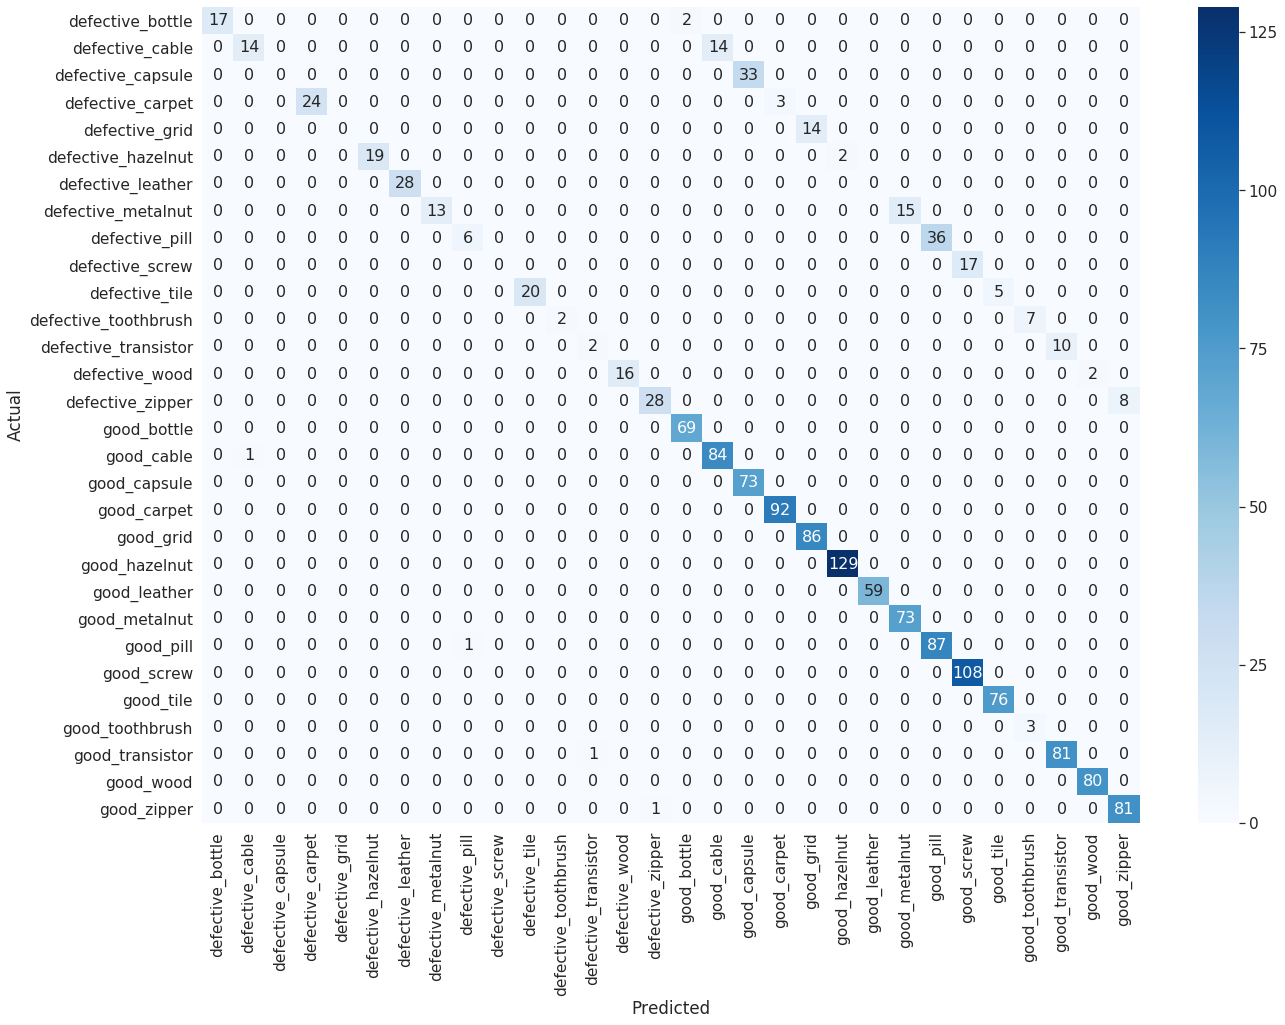

In [52]:
import seaborn as sn
    
plt_cm = pd.DataFrame(cm, index=test_generator.class_indices.keys(), columns=test_generator.class_indices.keys())
plt_cm.index.name = 'Actual'
plt_cm.columns.name = 'Predicted'
plt.figure(figsize = (21,15))
sn.set(font_scale=1.4)
sn.heatmap(plt_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt="d")
# plt.savefig('/content/drive/My Drive/xai_model/MVTec_RN101_50_CM.jpg')

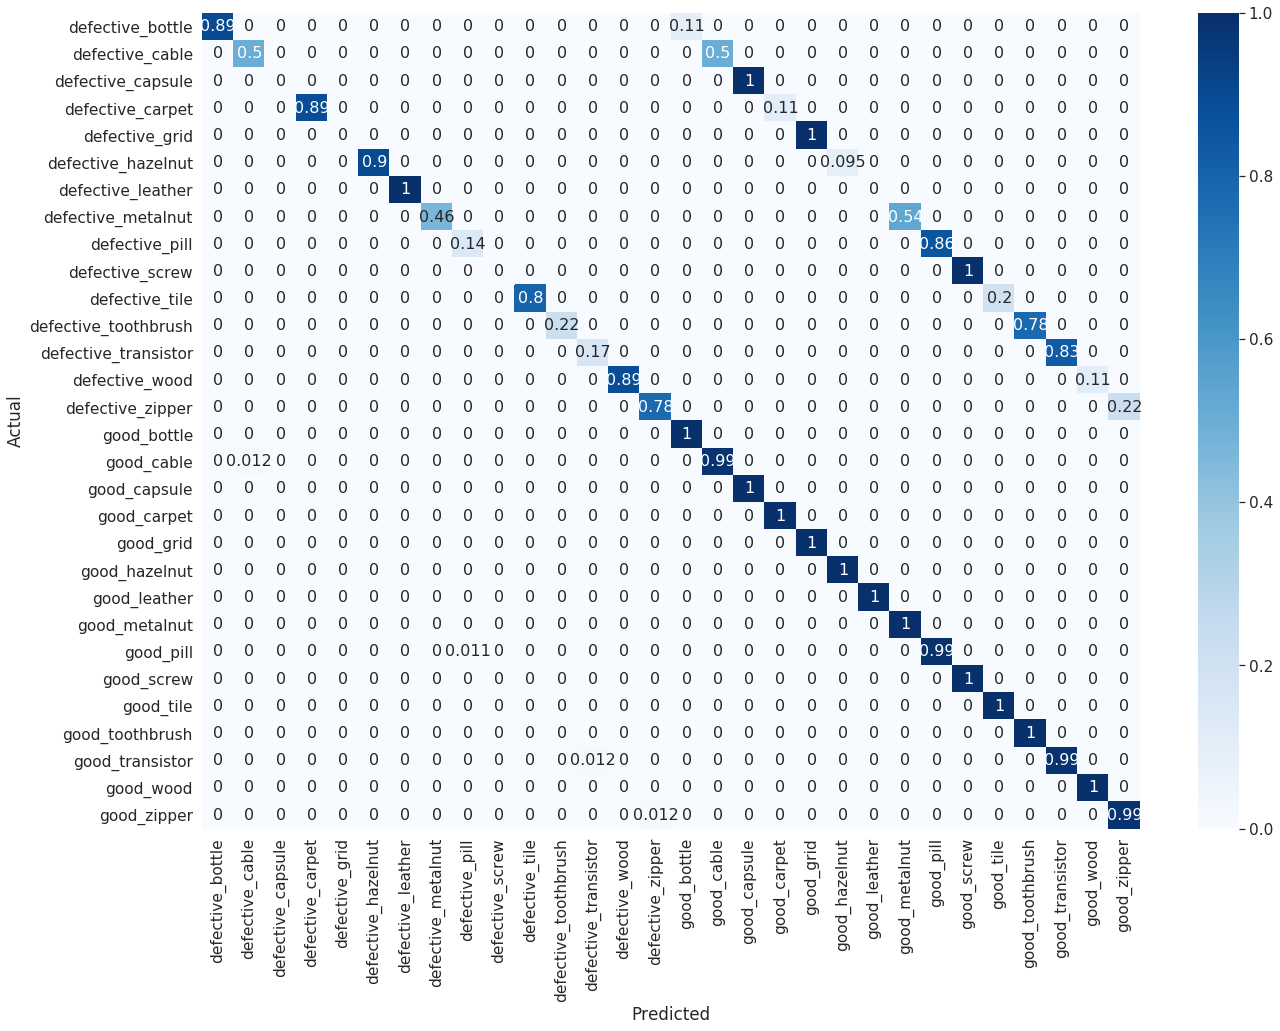

In [53]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt_cm = pd.DataFrame(cm_normalized, index=test_generator.class_indices.keys(), columns=test_generator.class_indices.keys())
plt_cm.index.name = 'Actual'
plt_cm.columns.name = 'Predicted'
plt.figure(figsize = (21,15))
sn.set(font_scale=1.4)
sn.heatmap(plt_cm, cmap="Blues", annot=True,annot_kws={"size": 16})
# plt.savefig('/content/drive/My Drive/xai_model/MVTec_RN101_50_CM_N.jpg')

# Prediction

In [0]:
image_path = "/content/drive/My Drive/data/test/defective_screw/screw_scratch_head_001.png"

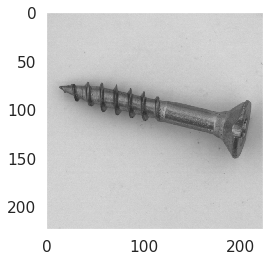

In [55]:
test_img = image.load_img(image_path, target_size=(224,224,3))
plt.grid(None)
plt.imshow(test_img)

test_img = image.img_to_array(test_img)
test_img = np.expand_dims(test_img, axis=0)
test_img /= 255

In [56]:
label_map_inv = {v:k  for k,v in label_map.items()}

result = model.predict(test_img)
print(result)

prediction = result.argmax(axis=1)
print(prediction)

output = label_map_inv[int(prediction)]
print("Output : ",output)

[[2.3985782e-05 4.9979171e-05 6.2206484e-05 5.7853763e-06 1.7845538e-05
  7.9023193e-06 1.2061257e-05 1.0391366e-05 1.3918678e-05 1.8028367e-01
  2.2238039e-05 8.9566793e-06 1.7281056e-05 2.7840184e-05 2.0477521e-05
  1.3953245e-05 3.3383218e-05 4.8816470e-05 4.1866165e-06 2.7861139e-05
  1.8498908e-05 1.6546077e-05 8.5143802e-06 1.7927554e-05 8.1914383e-01
  7.7159802e-06 5.9235726e-06 7.1961044e-06 2.8233599e-05 3.2847704e-05]]
[24]
Output :  good_screw


In [57]:
unique, counts_train = np.unique(train_generator.labels, return_counts=True)
print("Images per class in Training step: ",counts_train)
unique, counts_val = np.unique(val_generator.labels, return_counts=True)
print("\n Images per class in Validation step: ",counts_val)
unique, counts_test = np.unique(test_generator.labels, return_counts=True)
print("\n Images per class in Testing step : ",counts_test)

Images per class in Training step:  [ 36  52  61  50  26  40  52  52  80  33  48  17  23  34  67 128 158 136
 173 160 242 110 136 164 203 142   7 153 149 152]

 Images per class in Validation step:  [ 8 12 15 12  6  9 12 13 19  8 11  4  5  8 16 32 39 33 43 39 60 27 33 41
 50 35  1 38 37 38]

 Images per class in Testing step :  [ 19  28  33  27  14  21  28  28  42  17  25   9  12  18  36  69  85  73
  92  86 129  59  73  88 108  76   3  82  80  82]


In [0]:
# N = 30
# ind = np.arange(N)
# width = 0.5       # the width of the bars: can also be len(x) sequence

# p1 = plt.bar(ind, counts_train, width)
# p2 = plt.bar(ind, counts_val, width)
# p3 = plt.bar(ind, counts_test, width)

# # plt.ylabel('Scores')
# # plt.title('Scores by group and gender')
# # plt.xticks(ind, list(test_generator.class_indices.keys())[:5])
# # plt.yticks(np.arange(0, 81, 10))
# # plt.legend((p1[0], p2[0]), ('Men', 'Women'))
# # plt.figure(figsize = (21,15))
# # plt.grid(None)
# # plt.show()

# plt.grid(None)
# fig = plt.gcf()
# fig.set_size_inches(15, 8)

In [59]:
import plotly.graph_objects as go

headerColor = 'grey'

fig = go.Figure(data=[go.Table(
  header=dict(
    values=['<b>Class Labels</b>','<b>Training</b>','<b>Validation</b>','<b>Test</b>'],
    line_color='darkslategray',
    fill_color=headerColor,
    align=['left','center'],
    font=dict(color='white', size=12)
  ),
  cells=dict(
    values=[
      list(label_map.keys()),
      counts_train,
      counts_val,
      counts_test],
    line_color='darkslategray',
    # 2-D list of colors for alternating rows
    # fill_color = [[rowOddColor,rowEvenColor,rowOddColor, rowEvenColor,rowOddColor]*30],
    align = ['left', 'center'],
    font = dict(color = 'darkslategray', size = 11)
    ))
])

fig.update_layout(
    autosize=False,
    width=700,
    height=825,
    title_text = "Dataset distribution table"
)

fig.show()